In [44]:
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pandas
import matplotlib.dates as mdates
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py

import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [65]:
#buat variable bank
var_bank = 'BBNI'
df = pd.read_csv(f'/content/{var_bank}.JK.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-01,1102.052368,1102.052368,1054.652344,1102.052368,756.521545,70053643
1,2010-04-05,1125.752441,1125.752441,1102.052368,1125.752441,772.790955,44523108
2,2010-04-06,1113.902466,1125.752441,1090.202393,1113.902466,764.656128,75505108
3,2010-04-07,1125.752441,1125.752441,1090.202393,1125.752441,772.790955,117066198
4,2010-04-08,1102.052368,1125.752441,1090.202393,1102.052368,756.521545,32151828
...,...,...,...,...,...,...,...
3456,2024-03-22,5850.000000,5875.000000,5800.000000,5850.000000,5850.000000,29927600
3457,2024-03-25,5925.000000,5925.000000,5825.000000,5925.000000,5925.000000,43514000
3458,2024-03-26,5950.000000,5950.000000,5850.000000,5950.000000,5950.000000,29383900
3459,2024-03-27,5950.000000,5975.000000,5900.000000,5925.000000,5925.000000,19643200


In [46]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


SIMPLE MOVING AVERAGE

Mencari Teknikal indikator SMA (Simple Moving Average)

In [47]:
df['SMA_7'] = df['Close'].rolling(7).mean().shift()
df['SMA_14'] = df['Close'].rolling(14).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_7, name='SMA 7'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_14, name='SMA 14'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', line_color='dimgray', opacity=0.3))
fig.show()

Fungsi Mencari Teknikal indikator RSI(Relative Strength Index)

In [48]:
def RSI(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:] #menghilangkan nan di baris pertama
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI_7'] = RSI(df,n=7)
df['RSI_14'] = RSI(df)
df['RSI_30'] = RSI(df,n=30)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.RSI_7, name='RSI 7'))
fig.add_trace(go.Scatter(x=df.Date, y=df.RSI_14, name='RSI 14'))
fig.add_trace(go.Scatter(x=df.Date, y=df.RSI_30, name='RSI 30'))
fig.show()

Mencari EMA(Exponential Moving Average)  dan MACD (Moving Average Convergence Difference)

In [49]:
df['EMA_12'] = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
df['EMA_26'] = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(df.EMA_12 - df.EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.MACD, name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.MACD_signal, name='Signal line'), row=2, col=1)
fig.show()


Fungsi mencari stochastic oscilator

In [50]:
def stochastic(df, k, d):
    df = df.copy()
    low_min  = df['Low'].rolling(window=k).min()
    high_max = df['High'].rolling( window=k).max()
    df['stoch_k'] = 100 * (df['Close'] - low_min)/(high_max - low_min)
    df['stoch_d'] = df['stoch_k'].rolling(window=d).mean()
    return df

df = stochastic(df, k=14, d=3)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.stoch_k, name='K stochastic'))
fig.add_trace(go.Scatter(x=df.Date, y=df.stoch_d, name='D stochastic'))
fig.show()

Mencari Nilai Bollinger Bands

In [51]:
def bollinger_bands(df, window=20, num_std_dev=2):
  df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
  df['Rolling_Std'] = df['Close'].rolling(window=window).std()
  df['Bollinger_Upper'] = df['Rolling_Mean'] + (df['Rolling_Std'] * num_std_dev)
  df['Bollinger_Lower'] = df['Rolling_Mean'] - (df['Rolling_Std'] * num_std_dev)
  return df
def plot_bollinger_bands(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Close'], name='Close Price',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Rolling_Mean'], name='Rolling Mean',
        line=dict(color='orange')
    ))

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Bollinger_Upper'], name='Upper Band',
        line=dict(color='green')
    ))

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Bollinger_Lower'], name='Lower Band',
        line=dict(color='red')
    ))

    # Area shaded between upper and lower band
    fig.add_trace(go.Scatter(
        x=pd.concat([df['Date'], df['Date'][::-1]]),
        y=pd.concat([df['Bollinger_Upper'], df['Bollinger_Lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(128, 128, 128, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

    fig.update_layout(
        title=f'Bollinger Bands - {var_bank}',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white'
    )

    fig.show()


In [52]:
df = bollinger_bands(df)
plot_bollinger_bands(df)

Mencari Nilai Aroon Oscilator

In [53]:
def aroon_oscillator(df, window=25):
    df['Aroon_Up'] = 100 * df['Close'].rolling(window).apply(lambda x: np.argmax(x) / window, raw=False)
    df['Aroon_Down'] = 100 * df['Close'].rolling(window).apply(lambda x: np.argmin(x) / window, raw=False)
    df['Aroon_Oscillator'] = df['Aroon_Up'] - df['Aroon_Down']
    return df

def plot_aroon_oscillator(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Aroon_Up'], name='Aroon Up',
        line=dict(color='green')
    ))

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Aroon_Down'], name='Aroon Down',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Aroon_Oscillator'], name='Aroon Oscillator',
        line=dict(color='blue')
    ))

    fig.update_layout(
        title=f'Aroon Oscillator - {var_bank}',
        xaxis_title='Date',
        yaxis_title='Oscillator Value',
        template='plotly_white'
    )

    fig.show()


In [54]:
df = aroon_oscillator(df)
plot_aroon_oscillator(df)

Mencari Nilai Momentum


In [55]:
def momentum(df, window=10):
    df['Momentum'] = df['Close'] - df['Close'].shift(window)
    return df

def plot_momentum(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Momentum'], name='Momentum',
        line=dict(color='blue')
    ))

    fig.update_layout(
        title=f'Momentum - {var_bank}',
        xaxis_title='Date',
        yaxis_title='Momentum',
        template='plotly_white'
    )

    fig.show()


In [56]:
df = momentum(df)
plot_momentum(df)

Mencari Nilai WMA (Weighted Moving Average)


In [57]:
def weighted_moving_average(df, window=10):
    weights = np.arange(1, window+1)
    df['WMA'] = df['Close'].rolling(window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return df

def plot_wma(df):
    fig = go.Figure()

    # Garis harga penutupan
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Close'], name='Close Price',
        line=dict(color='blue')
    ))

    # Garis Weighted Moving Average
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['WMA'], name='Weighted Moving Average (WMA)',
        line=dict(color='orange')
    ))

    fig.update_layout(
        title=f'Weighted Moving Average (WMA) - {var_bank}',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white'
    )

    fig.show()


In [58]:
df = weighted_moving_average(df)
plot_wma(df)

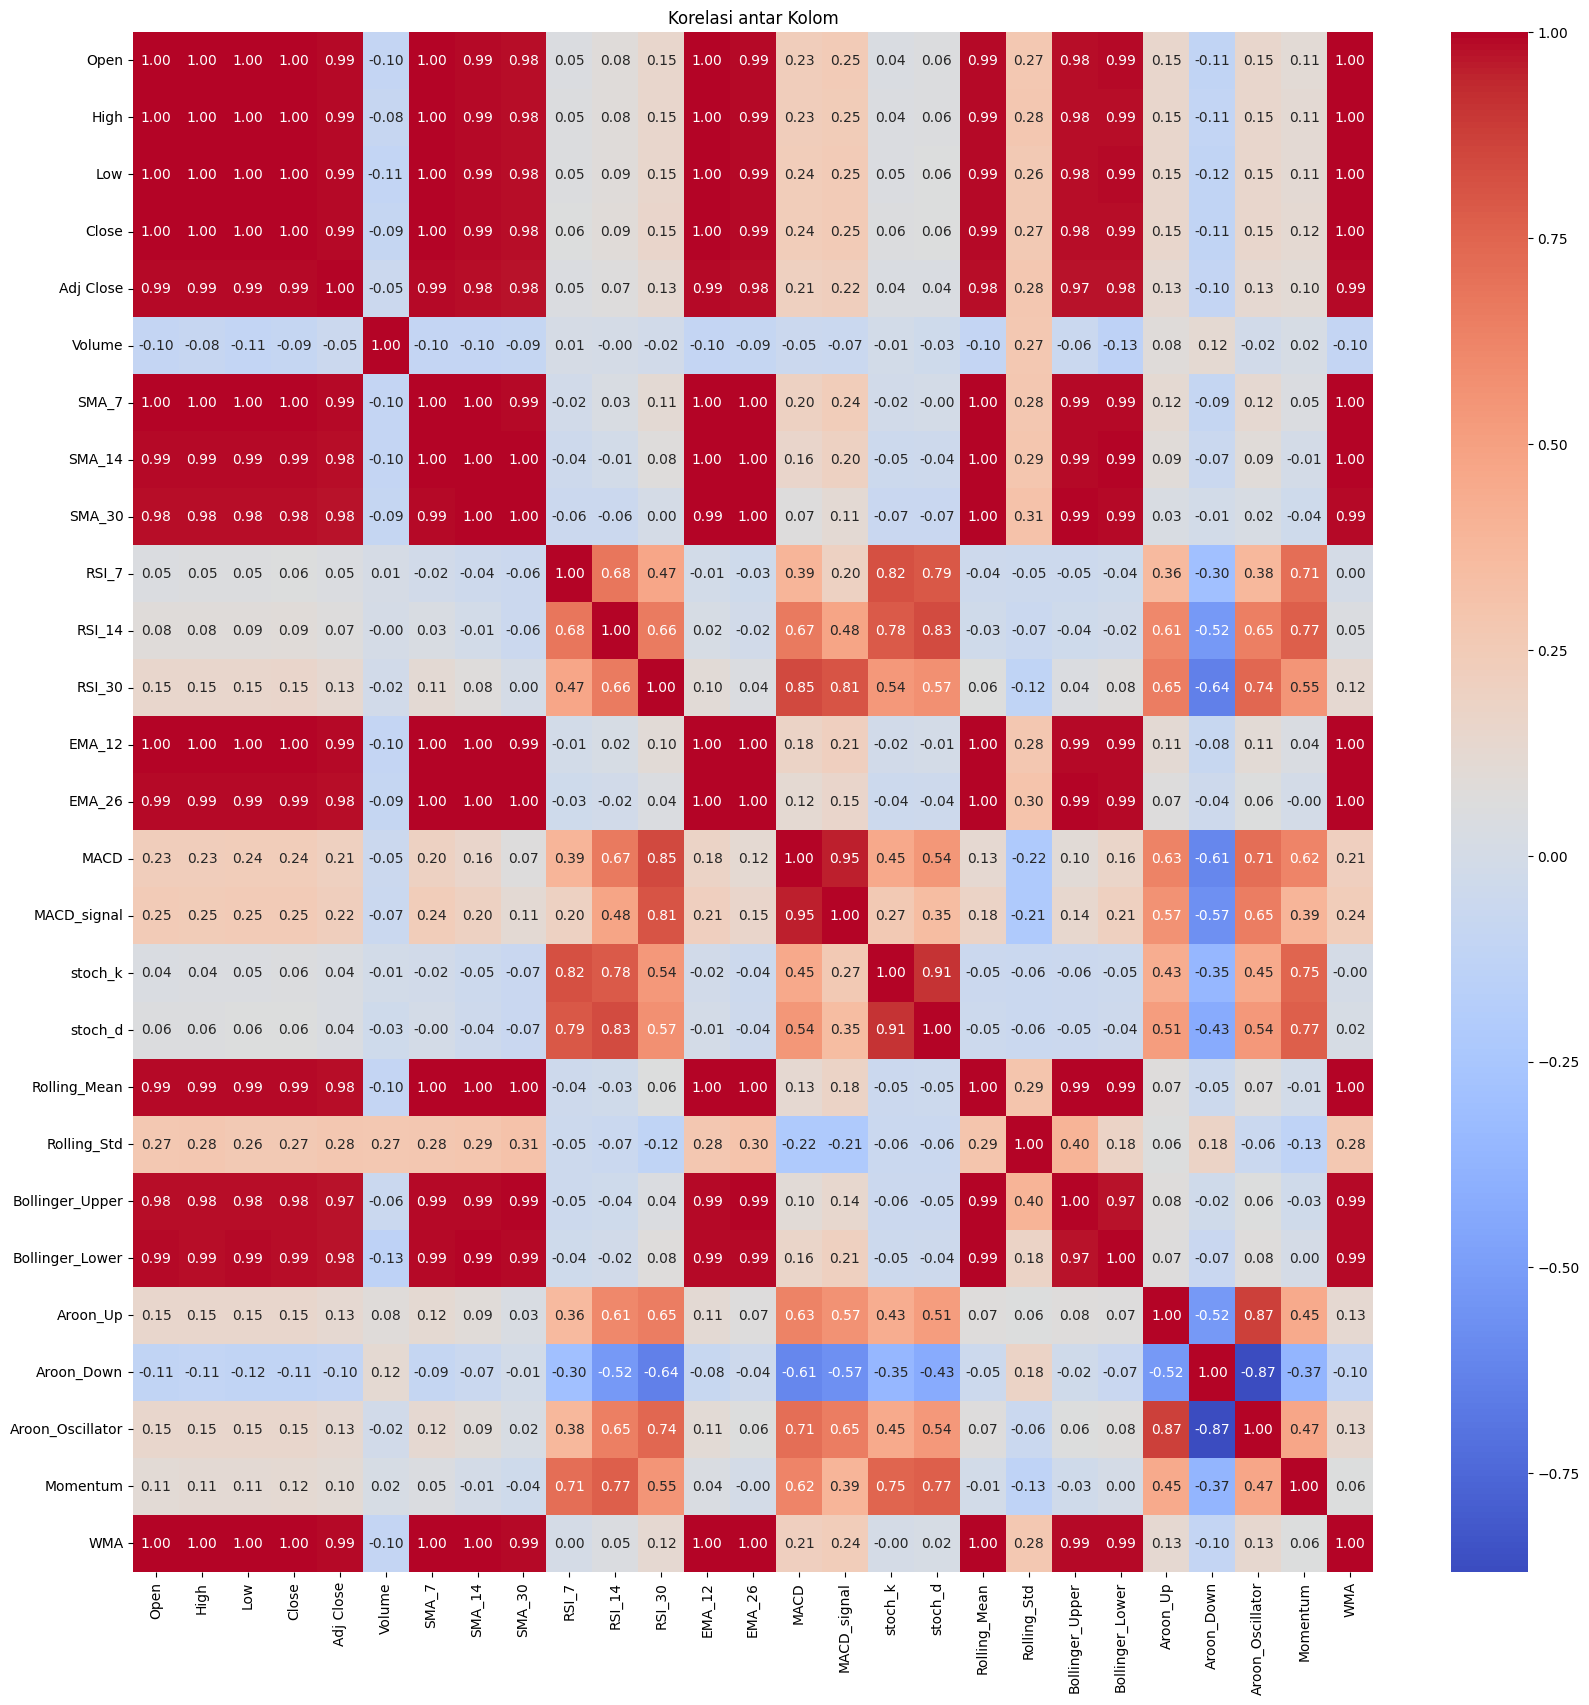

In [59]:
df1 = df.drop('Date', axis=1)
correlation_matrix = df1.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi antar Kolom')
plt.show()

In [60]:
df1 = df1.dropna(axis=0)
# Hitung matriks korelasi
correlation_matrix = df1.corr().abs()

# Tentukan kolom target
target_columns = ['Close', 'Open', 'Low', 'High']

# Ambil kolom yang korelasinya di atas 50% dengan kolom target
columns_to_keep = set(target_columns)  # Awalnya, simpan kolom target
for target in target_columns:
    correlated_cols = correlation_matrix.index[correlation_matrix[target] > 0.7].tolist()
    columns_to_keep.update(correlated_cols)

# Tambahkan kolom 'Date' dan pastikan berada di urutan pertama
columns_to_keep.add('Date')
columns_to_keep = ['Date'] + [col for col in columns_to_keep if col != 'Date']  # Urutkan agar 'Date' di kiri

# Filter DataFrame hanya dengan kolom yang korelasinya tinggi terhadap target
df_filtered = df[columns_to_keep]


In [61]:
df_filtered = df_filtered.dropna(axis=0)
df_filtered.to_csv(f'{var_bank}_FS.csv',index=False)

In [62]:
df_filtered

,Date,Bollinger_Upper,SMA_7,High,SMA_30,Low,Open,Bollinger_Lower,Close,Rolling_Mean,EMA_12,EMA_26,WMA,Adj Close,SMA_14
30,2010-05-17,1230.128298,1137.602487,1161.302612,1142.737496,1137.602539,1161.302612,1090.106785,1161.302612,1160.117541,1155.502571,1152.182785,1150.529805,797.194702,1160.456107
31,2010-05-18,1230.970507,1142.681082,1196.852661,1144.712504,1161.302612,1185.002563,1096.374586,1185.002563,1163.672546,1160.062777,1154.840300,1156.993450,813.463928,1158.763253
32,2010-05-19,1230.355122,1154.531110,1173.152588,1146.687508,1125.752441,1137.602539,1098.174980,1137.602539,1164.265051,1156.593357,1153.454071,1154.838909,780.925537,1160.456107
33,2010-05-20,1231.726101,1159.609706,1161.302612,1147.477510,1066.502319,1113.902466,1092.063987,1113.902466,1161.895044,1150.003028,1150.293454,1149.237083,764.656128,1159.609680
34,2010-05-21,1229.109492,1154.531128,1090.202393,1147.082511,1042.802246,1090.202393,1082.830571,1090.202393,1155.970032,1140.776275,1145.519371,1139.541606,748.386963,1154.531102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,2024-03-22,6168.438003,5928.571429,5875.000000,5923.333333,5800.000000,5850.000000,5709.061997,5850.000000,5938.750000,5901.486696,5884.071390,5889.090909,5850.000000,5942.857143
3457,2024-03-25,6167.202325,5875.000000,5925.000000,5925.833333,5825.000000,5925.000000,5707.797675,5925.000000,5937.500000,5905.104128,5887.103139,5885.909091,5925.000000,5932.142857
3458,2024-03-26,6169.071352,5842.857143,5950.000000,5931.666667,5850.000000,5950.000000,5710.928648,5950.000000,5940.000000,5912.011185,5891.762165,5888.181818,5950.000000,5933.928571
3459,2024-03-27,6169.674236,5864.285714,5975.000000,5937.500000,5900.000000,5950.000000,5712.825764,5925.000000,5941.250000,5914.009464,5894.224227,5888.636364,5925.000000,5939.285714


In [63]:
df_tanpa_fs = df.dropna()
df_tanpa_fs.to_csv(f'{var_bank}_noFS.csv',index=False)
df_tanpa_fs


,Date,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,SMA_30,...,stoch_d,Rolling_Mean,Rolling_Std,Bollinger_Upper,Bollinger_Lower,Aroon_Up,Aroon_Down,Aroon_Oscillator,Momentum,WMA
33,2010-05-20,1113.902466,1161.302612,1066.502319,1113.902466,764.656128,43668680,1159.609706,1159.609680,1147.477510,...,54.166680,1161.895044,34.915528,1231.726101,1092.063987,44.0,4.0,40.0,-11.849975,1149.237083
34,2010-05-21,1090.202393,1090.202393,1042.802246,1090.202393,748.386963,42953492,1154.531128,1154.531102,1147.082511,...,38.055578,1155.970032,36.569730,1229.109492,1082.830571,40.0,96.0,-56.0,-11.849975,1139.541606
35,2010-05-24,1125.752441,1125.752441,1090.202393,1125.752441,772.790955,47644409,1147.759678,1144.373936,1146.687512,...,36.944450,1153.007525,36.493867,1225.995260,1080.019791,36.0,92.0,-56.0,23.700073,1136.525228
36,2010-05-25,1090.202393,1102.052368,1042.802246,1090.202393,748.386963,59701345,1142.681082,1140.141784,1147.477514,...,34.700856,1148.267517,38.234521,1224.736559,1071.798475,32.0,88.0,-56.0,-59.250122,1126.614296
37,2010-05-26,1137.602539,1137.602539,1090.202393,1137.602539,780.925537,59264637,1129.138201,1133.370344,1146.687512,...,46.324793,1147.082513,38.176485,1223.435484,1070.729543,28.0,84.0,-56.0,0.000000,1126.398846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,2024-03-22,5850.000000,5875.000000,5800.000000,5850.000000,5850.000000,29927600,5928.571429,5942.857143,5923.333333,...,22.222222,5938.750000,114.844002,6168.438003,5709.061997,68.0,76.0,-8.0,-100.000000,5889.090909
3457,2024-03-25,5925.000000,5925.000000,5825.000000,5925.000000,5925.000000,43514000,5875.000000,5932.142857,5925.833333,...,25.396825,5937.500000,114.851162,6167.202325,5707.797675,64.0,72.0,-8.0,-50.000000,5885.909091
3458,2024-03-26,5950.000000,5950.000000,5850.000000,5950.000000,5950.000000,29383900,5842.857143,5933.928571,5931.666667,...,34.920635,5940.000000,114.535676,6169.071352,5710.928648,60.0,68.0,-8.0,-150.000000,5888.181818
3459,2024-03-27,5950.000000,5975.000000,5900.000000,5925.000000,5925.000000,19643200,5864.285714,5939.285714,5937.500000,...,39.682540,5941.250000,114.212118,6169.674236,5712.825764,56.0,64.0,-8.0,-300.000000,5888.636364
